<a href="https://colab.research.google.com/github/shinmiura/diveintocode-ml/blob/master/%E3%83%8B%E3%83%A5%E3%83%BC%E3%83%A9%E3%83%AB%E3%83%8D%E3%83%83%E3%83%88%E3%83%AF%E3%83%BC%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 必要なライブラリの読み込み

%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from IPython.display import Image, display_png

In [ ]:
# digitsデータを使うためにimportする
from torchvision.datasets import MNIST
import torchvision

In [ ]:
# GPUが使えるか否かの確認(使える場合は「cuda」、使えない場合は「cpa」と表示される)
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'
print(device)

cuda


In [6]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

# 1.このSprintについて

**Sprintの目的**

・スクラッチを通してニューラルネットワークの基礎を理解する

・画像データの扱い方を知る

**どのように学ぶか**

スクラッチで単純なニューラルネットワークを実装した後、学習と検証を行なっていきます。

# 2.MNISTデータセット

ニューラルネットワークスクラッチの検証にはMNISTデータセットを使用します。各種ライブラリやサイトからダウンロードできますが、ここでは深層学習フレームワークのKerasを用います。以下のコードを実行すればデータセットをダウンロードし、展開まで行えます。


《データセットをダウンロードするコード》

In [7]:
from keras.datasets import mnist
# データの読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

《MNISTとは？》


画像分類のための定番データセットで、手書き数字認識を行います。このデータセットには訓練用6万枚、テスト用1万枚の28×28ピクセルの白黒画像、およびそれらが0〜9のどの数字であるかというラベルが含まれています。


《画像データとは？》


デジタル画像は点の集合で、これをピクセルと呼びます。一般的に白黒画像であればピクセルには0〜255の値が含まれます。一方、カラー画像であればR（赤）、G（緑）、B（青）それぞれに対応する0〜255の値が含まれます。機械学習をする上では、この0〜255の値一つひとつが特徴量として扱われます。0〜255は符号なしの8ビット整数で表せる範囲になるため、NumPyであれば「uint8」型の変数として保持できます。

**データセットの確認**

どういったデータなのかを見てみます。


《サンプルコード》

In [8]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [9]:
# データの確認
print('全trainデータ:{}'.format(X_train.shape))
print('全testデータ:{}'.format(X_test.shape))
print('trainデータの中の１つのデータ:{}'.format(X_train[0].shape))
print('trainデータの中の１つのデータの型:{}'.format(X_train[0].dtype))

全trainデータ:(60000, 28, 28)
全testデータ:(10000, 28, 28)
trainデータの中の１つのデータ:(28, 28)
trainデータの中の１つのデータの型:uint8


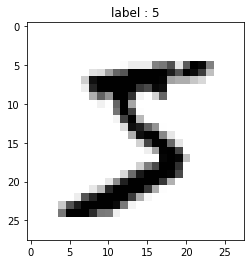

In [10]:
# trainデータの画像を描画して表示
index = 0
# grayに_rを付けて色を逆転させた(∵個人的に黒字が見やすい)。interpolationで画像を拡大表示する時の補完方法を指定。
plt.imshow(X_train[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.title('label : {}'.format(y_train[index]))
plt.show()

各データは28×28ピクセルの白黒画像です。

**平滑化**

(1, 28, 28)の各画像を、(1, 784)に変換します。これまで学んできた機械学習手法や、今回扱う全結合層のみのニューラルネットワークではこの形で扱います。すべてのピクセルが一列になっていることを、 平滑化（flatten） してあるという風に表現します。


《サンプルコード》



In [11]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

《補足》


ここまで機械学習を学んでくる中で、特徴量の数を「次元」と呼んできました。その視点ではMNISTは784次元のデータです。一方で、NumPyのshapeが(784,)の状態を1次元配列とも呼びます。画像としての縦横の情報を持つ（28, 28)の状態であれば、2次元配列です。この視点では2次元のデータです。さらに、もしカラー画像であれば(28, 28, 3)ということになり、3次元配列です。先ほどの視点では3次元のデータになります。しかし、白黒でもカラーでも平面画像であり、立体データではないという視点で、2次元のデータです。画像データを扱う際にはこのように「次元」という言葉が複数の意味合いで使われることに注意してください。

In [12]:
# 画像データを一直線に並べる
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [13]:
# データの確認
print('全trainデータ:{}'.format(X_train.shape))
print('全testデータ:{}'.format(X_test.shape))
print('trainデータの中の１つのデータ:{}'.format(X_train[0].shape))
print('trainデータの中の１つのデータの型:{}'.format(X_train[0].dtype))

全trainデータ:(60000, 784)
全testデータ:(10000, 784)
trainデータの中の１つのデータ:(784,)
trainデータの中の１つのデータの型:uint8


**画像データの可視化**

画像データを可視化します。plt.imshowに渡します。


《サンプルコード》

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

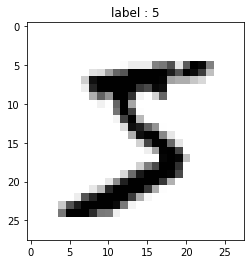

In [14]:
# import matplotlib.pyplot as plt (一番上で定義呼び出し済のためコメントアウト)
# %matplotlib inline (一番上で定義呼び出し済のためコメントアウト)
# 上記雛形は先頭のデータをしているが、n番目のデータというのはここで変更できる
index = 0
# X_train[index]: (784,)
# image: (28, 28)
# grayに_rを付けて色を逆転させた(∵個人的に黒字が見やすい)。interpolationで画像を拡大表示する時の補完方法を指定。
plt.imshow(X_train[index].reshape(28, 28), cmap = plt.cm.gray_r, interpolation = 'nearest')
plt.title('label : {}'.format(y_train[index]))
plt.show()

numpy.reshape — NumPy v1.17 Manual


matplotlib.pyplot.imshow — Matplotlib 3.1.1 documentation


《発展的話題》


画像データは符号なし8ビット整数のuint8型で保持されることが一般的ですが、plt.imshowはより自由な配列を画像として表示することが可能です。例えば、以下のようにマイナスの値を持ったfloat64型の浮動小数点であってもエラーにはならないし、先ほどとまったく同じ風に表示されます。



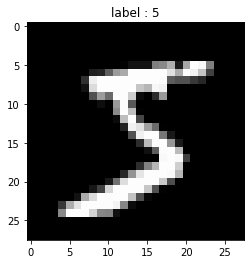

[[-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35
  -105.35]
 [-105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -105.35 -1

In [15]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
print(image) # 値を確認

これは、自動的に値を0〜255の整数に変換して処理するように作られているからです。uint8型であっても最小値が0、最大値が255でない場合には色合いがおかしくなります。それを防ぐためには次のように引数を入れてください。

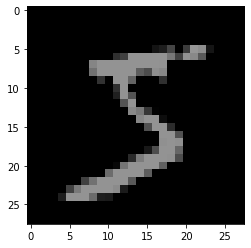

In [16]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

画像関係のライブラリではこの自動的なスケーリングが思わぬ結果を生むことがあるので、新しいメソッドを使うときには確認しておきましょう。

**前処理**

画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。以下のコードで変換可能です。


《サンプルコード》

In [ ]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

In [17]:
# NNの入力値にするため、0〜1の範囲に収める
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
# 色の階調が255であるため255で割ると講義内で説明あり
X_train /= 255
X_test /= 255
# 0〜1の範囲内に収まっているか確認
print('trainデータの最大値:{}、最小値:{}'.format(X_train.max(), X_train.min()))

trainデータの最大値:1.0、最小値:0.0


また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

《サンプルコード》

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

In [18]:
# from sklearn.preprocessing import OneHotEncoder (一番上で定義呼び出し済のためコメントアウト)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [19]:
# trainデータを分割してバリデーションデータを作成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

In [20]:
# from sklearn.preprocessing import OneHotEncoder (一番上で定義呼び出し済のためコメントアウト)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis]) # add
print('trainデータの目的変数:{}'.format(y_train.shape)) # (48000,)
print(y_train_one_hot.shape) # (48000, 10)
print(y_train_one_hot.dtype) # float64
print('testデータの目的変数:{}'.format(y_test.shape)) # (10000,)
print('validationデータの目的変数:{}'.format(y_val.shape)) # (12000,)

trainデータの目的変数:(48000,)
(48000, 10)
float64
testデータの目的変数:(10000,)
validationデータの目的変数:(12000,)


sklearn.preprocessing.OneHotEncoder — scikit-learn 0.21.3 documentation


さらに、訓練データ6万枚の内2割を検証データとして分割してください。訓練データが48000枚、検証データが12000枚となります。


《サンプルコード》

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(38400, 784)
(9600, 784)


# 3.ニューラルネットワークスクラッチ

ニューラルネットワークのクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


今回は多クラス分類を行う3層のニューラルネットワークを作成します。層の数などは固定した上でニューラルネットワークの基本を学びます。次のSprintで層を自由に変えられる設計にしていきます。


以下に雛形を用意してあります。このScratchSimpleNeuralNetrowkClassifierクラスにコードを書き加えていってください。

In [ ]:
# 《雛形》
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, verbose = True):
        self.verbose = verbose
        pass
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        pass
        return


In [37]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, sigma = 0.02, lr = 0.01, epoch = 10, verbose = True):
        """
        学習に必要なインスタンス変数の初期化
        Parameters
        ----------
        verbose : 計算過程を出力するか否か
        batch_size : ミニバッチのデータ数
        n_features : 説明変数の数
        n_nodes1 : 1層目のノードの数
        n_nodes2 : 2層目のノードの数
        n_output : 出力層のノードの数
        sigma : 重みの初期化の際のガウス分布の標準偏差
        lr : 学習率
        epoch : 学習回数
        """
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        # 損失記録用
        self.loss_train = []
        self.loss_val = [] # change
        # 使用する重みの初期化(問題１の解答をここに記載する)
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)

    def fit(self, X, y, X_val=None, y_val=None): # change
        """
        ニューラルネットワーク分類器を学習する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        
        Overview
        -----------
        学習回数分学習を繰り返すが、各学習の中でもミニバッチで全データ学習させている。
        イメージとしては、下記
        学習０回目
        ミニバッチ学習０回目→ミニバッチ学習１回目→・・・
        学習１回目
        ミニバッチ学習０回目→ミニバッチ学習１回目→・・・
        ・・・・
        """
        # 学習回数分ループ
        for _ in range(self.epoch):

          # 先ほど定義したミニバッチイテレータのインスタンス化
          get_mini_batch = GetMiniBatch(X, y, batch_size = self.batch_size)

          # ミニバッチイテレータが停止するまでバッチ学習
          # get_mini_batchを呼び出すたびに、説明変数と目的変数が返ってくる
          for mini_X_train, mini_y_train in get_mini_batch:
            # 順伝播
            self.forward(mini_X_train)
            # 逆伝播
            self.backward(mini_X_train, mini_y_train)
          
          # ミニバッチ学習後のロス計算
          self.forward(X)
          self.loss_train.append(self.cross_entropy_error(y, self.Z3))
          # 評価データがあるなら、こちらも計算
          if X_val is not None:
            self.forward(X_val)
            self.loss_val.append(self.cross_entropy_error(y_val, self.Z3))

        # 学習過程の出力
        if self.verbose:
          if X_val is None: # change
            print(self.loss_train)
          else:
            print(self.loss_train, self.loss_val) # change
            
    # 問題２の解答をここに記載する
    def forward(self, X):
      """
      順伝播
      Parameters
      ----------
      X　：　説明変数
      """
      ## 1層目
      # 活性化関数に通す前
      self.A1 = X @ self.W1 + self.B1
      # 上記を活性化関数に通す
      self.Z1 = self.tanh_function(self.A1)

      ## 2層目
      # 活性化関数に通す前
      self.A2 = self.Z1 @ self.W2 + self.B2
      # 上記を活性化関数に通す
      self.Z2 = self.tanh_function(self.A2)

      ## 3層目(出力層)
      # 活性化関数に通す前
      self.A3 = self.Z2 @ self.W3 + self.B3
      # 上記を活性化関数に通す
      self.Z3 = self.softmax(self.A3)

      # メンバ変数self.Z3がNNの出力となる
    
    # 問題４の解答をここに記載する
    def backward(self, X, y):
      """
      逆伝播
      Parameters
      ----------
      X : 説明変数
      """
      ## 3層目(出力層)
      # 3層目の重みに対する勾配
      dA3 = (self.Z3 - y) / self.batch_size # change
      dW3 = self.Z2.T @ dA3
      # 3層目のバイアス項に対する勾配
      dB3 = np.sum(dA3, axis = 0)

      ## 2層目
      # 2層目の重みに対する勾配
      dZ2 = dA3 @ self.W3.T
      dA2 = dZ2 * (1- self.tanh_function(self.A2) ** 2)
      dW2 = self.Z1.T @ dA2
      # 2層目のバイアス項に対する勾配
      dB2 = np.sum(dA2, axis = 0)

      ## 1層目
      # 1層目の重みに対する勾配
      dZ1 = dA2 @ self.W2.T
      dA1 = dZ1 * (1 - self.tanh_function(self.A1) ** 2)
      dW1 = X.T @ dA1
      # 1層目のバイアスに対する勾配
      dB1 = np.sum(dA1, axis = 0)

      # 各勾配に学習率を掛けて更新
      self.W3 -= self.lr * dW3
      self.B3 -= self.lr * dB3
      self.W2 -= self.lr * dW2
      self.B2 -= self.lr * dB2
      self.W1 -= self.lr * dW1
      self.B1 -= self.lr * dB1
    
    def tanh_function(self, A):
      """
      活性化関数tanh
      Parameters
      ----------
      A : 何かしらの配列
      """
      return np.tanh(A)
    
    def softmax(self, A):
      """
      活性化関数softmax
      parameters
      ----------
      A : 何かしらの配列
      """
      return np.exp(A) / np.sum(np.exp(A), axis = 1).reshape(-1, 1)
    
    # 問題３の解答をここに記載する
    def cross_entropy_error(self, y, Z):
      """
      損失関数　　クロスエントロピー誤差
      Parameters
      ----------
      y : 正解データ
      Z : 予測値
      """
      L = - np.sum(y * np.log(Z)) / len(y)
      return L

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 説明変数
        """
        # 順伝播処理
        self.forward(X)
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(self.Z3, axis = 1)

In [38]:
# イテレータの基本
class SampleIterator:
  def __init__(self, num):
    """
    通常のコンストラクタと同様の働き
    """
    # 最大呼び出し回数
    self.num = num
  
  def __iter__(self):
    """
    呼び出される際は、まずここが呼ばれる
    return self 部分は、このインスタンス自身を返している
    """
    # 現在位置
    self.current = 0
    return self
  
  def __next__(self):
    """
    基本的にここに返してやりたい処理を書く
    """
    # 現在位置が最大呼び出し回数に達したかの判定
    if self.current == self.num:
      raise StopIteration()
    
    # 返してやりたい値
    value = self.current

    # 現在位置を進める
    self.current += 1

    return value

In [26]:
sample_iter = SampleIterator(3)
for i in sample_iter:
    print(i)

0
1
2


ミニバッチ処理

これまでの機械学習スクラッチでは、すべてのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。


今回はバッチサイズを20とします。今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練データを一度すべて見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。


これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。


《コード》



In [ ]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __iniit__(self, x, y, batch_size = 20, seed = 0):
      """
      通常のコンストラクタと同様の動き
      Parameters
      ----------
      X : 説明変数(画像の１次元データ)
      y : 目的変数(ラベル)
      batch_size : 必要なミニバッチのデータ数
      seed : ランダムシード固定
      """
      # バッチ数のメンバ変数
      self.batch_size = batch_size
      # ランダムシードの固定(学習ごとに同じ生成順)
      np.random.seed(seed)
      # データ全体の長さ分のインデックスをランダムに並べ替え
      shuffle_index = np.random.permutation(np.arange(X.shape[0]))  # np.random.permutationで配列をランダムに並べ替え
      # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
      self._X = X[shuffle_index]
      self._y = y[shuffle_index]
      # 必要となる呼び出し回数(データ数をバッチ数で割ると全データを学習するのに必要なバッチ呼び出し回数が出せる)
      self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

      def __len__(self):
        return self._stop
      
      def __iter__(self):
        # 呼び出し回数のカウント
        self._counter = 0
        return self
      
      def __next__(self):
        # 全データを学習できた時点で止める
        if self._counter >= self.stop:
          raise StopIteration
        # 並び替え後の_Xと_yの何番目のインデックスを採用するか
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]

In [39]:
# 訓練データの中からランダムに一部のデータを選び出したものがミニバッチ。
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed = 1234):
      """
      通常のコンストラクタと同様の動き
      Parameters
      ----------
      X : 説明変数(画像の１次元データ)
      y : 目的変数(ラベル)
      batch_size : 必要なミニバッチのデータ数
      seed : ランダムシード固定
      """
      # バッチ数のメンバ変数
      self.batch_size = batch_size
      # ランダムシードの固定(学習ごとに同じ生成順)
      np.random.seed(seed)
      # データ全体の長さ分のインデックスをランダムに並べ替え
      # np.random.permutation:配列をランダムに並べ替え
      shuffle_index = np.random.permutation(np.arange(X.shape[0]))
      # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え 
      self._X = X[shuffle_index]
      self._y = y[shuffle_index]
      self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    # def __getitem__(self,item):
        # p0 = item*self.batch_size
        # p1 = item*self.batch_size + self.batch_size
        # return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]

このクラスをインスタンス化し、for文を使うことでミニバッチが取り出せます。

In [ ]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

__getitem__や__next__は__init__と同じ特殊メソッドの一種です。

**学習**

ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲーションの繰り返しになります。

**【問題1】重みの初期値を決めるコードの作成**

ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。


重みの初期値はさまざまな方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。


以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。


《サンプルコード》



In [ ]:
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)

numpy.random.randn — NumPy v1.15 Manual

**【問題2】フォワードプロパゲーションの実装**

三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。


各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。



In [ ]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

「1層目」

$$
A_1 = X \cdot W_1 + B_1
$$

$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)


$B_1$ : 1層目のバイアス (n_nodes1,)


$A_1$ : 出力 (batch_size, n_nodes1)


「1層目の活性化関数」

$$
Z_1 = f(A_1)
$$

$f()$ : 活性化関数


$Z_1$ 出力 (batch_size, n_nodes1)


「2層目」

$$
A_2 = Z_1 \cdot W_2 + B_2
$$

$W_2$ : 2層目の重み (n_nodes1, n_nodes2)


$B_2$ : 2層目のバイアス (n_nodes2,)


$A_2$ : 出力 (batch_size, n_nodes2)


「2層目の活性化関数」

$$
Z_2 = f(A_2)
$$

$f()$ : 活性化関数


$Z_2$ 出力 (batch_size, n_nodes2)


「3層目（出力層）」

$$
A_3 = Z_2 \cdot W_3 + B_3
$$

$W_3$ : 3層目の重み (n_nodes2, n_output)


$B_3$ : 3層目のバイアス (n_output,)


$A_3$ : 出力 (batch_size, n_output)


「3層目の活性化関数」

$$
Z_3 = softmax(A_3)
$$

$softmax()$ : ソフトマックス関数


$Z_3$ 出力 (batch_size, n_output)


$Z_3$ は各ラベル（0〜9）に対する確率の配列である。



**活性化関数（フォワードプロバゲーション）**

活性化関数を作成し、フォワードプロパゲーションの中で使用します。切り替えられるように実装することを推奨しますが、片方でも構いません。


「シグモイド関数」

$$
f(Z) = sigmoid(A) = \frac{1}{1+exp(-A)}
$$
指数関数 $exp(-A)$ の計算はnp.expを使用してください。


numpy.exp — NumPy v1.15 Manual


「ハイパボリックタンジェント関数」


次の数式で表されますが、np.tanhひとつで実現できます。

$$
f(Z) = tanh(A) = \frac{exp(A) - exp(-A)}{exp(A) + exp(-A)}
$$

numpy.tanh — NumPy v1.15 Manual


＊現在ではこれらの代わりにReLUと呼ばれる活性化関数が一般的です。次のSprintで扱います。



**ソフトマックス関数**

ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。


次の数式です。

$$
Z_{3\_k} = \frac{exp(A_{3\_k})}{\sum_{i=1}^{n_c}exp(A_{3\_i})}
$$

$Z_{3_k}$ : $k$ 番目のクラスの確率ベクトル (batch_size,)


$A_{3_k}$ : $k$ 番目のクラスにあたる前の層からのベクトル (batch_size,)


$n_c$ : クラスの数、n_output。今回のMNISTでは10。


分母はすべてのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に $k$ 番目のクラスを持ってくることで、 $k$ 番目のクラスである確率が求まります。


これを10クラス分計算し、合わせたものが $Z_3$ です。

【問題3】交差エントロピー誤差の実装

目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 $L$ は次の数式です。

$$
L = - \frac{1}{n_b}\sum_{i}^{n_b}\sum_{j}^{n_c}y_{ij} log(z_{3\_ij})
$$

$y_{ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）


$z_{3_ij}$ : $j$ 番目のサンプルの $k$ 番目のクラスの確率（スカラー）


$n_{b}$ : バッチサイズ、batch_size


$n_{c}$ : クラスの数、n_output（今回のMNISTでは10）


サンプル1つあたりの誤差が求まります。


実数におけるlog(x)の定義域は0 < xです。したがって、logの中身がとても小さい値になってしまったときエラーを起こします。そこでlogの中に1e-7を足すことでエラーを回避できます。


こういった処理はlogに限らず、さまざまな場所で出てくることがあります。



【問題4】バックプロパゲーションの実装

三層のニューラルネットワークのバックプロパゲーションを作成してください。確率的勾配降下法を行う部分です。


数式を以下に示します。


まず、i層目の重みとバイアスの更新式です。 $W_i$ と $B_i$ に対し、更新後の $W_i^{\prime}$ と $B_i^{\prime}$ は次の数式で求められます。

$$
W_i^{\prime} = W_i - \alpha \frac{\partial L}{\partial W_i} \\
B_i^{\prime} = B_i - \alpha \frac{\partial L}{\partial B_i}
$$

$\alpha$ : 学習率（層ごとに変えることも可能だが、基本的にはすべて同じとする）


$\frac{\partial L}{\partial W_i}$ : $W_i$ に関する損失 $L$ の勾配


$\frac{\partial L}{\partial B_i}$ : $B_i$ に関する損失 $L$ の勾配


＊この勾配はミニバッチのサンプル数分の合計または平均を考えます。ここでは合計を計算します。


この更新方法はSprint3線形回帰やsprint4ロジスティック回帰における最急降下法と同様です。より効果的な更新方法が知られており、それは次のSprintで扱います。


勾配 $\frac{\partial L}{\partial W_i}$ や $\frac{\partial L}{\partial B_i}$ を求めるために、バックプロパゲーションを行います。以下の数式です。ハイパボリックタンジェント関数を使用した例を載せました。シグモイド関数の場合の数式はその後ろにあります。

「3層目」

$$
\frac{\partial L}{\partial A_3} = \frac{1}{n_b}(Z_{3} - Y)\\
\frac{\partial L}{\partial B_3} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{3\_j}}\\
\frac{\partial L}{\partial W_3} = Z_{2}^{T}\cdot \frac{\partial L}{\partial A_3}\\
\frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_3} \cdot W_3^T
$$


$\frac{\partial L}{\partial A_3}$ : $A_3$ に関する損失 $L$ の勾配 (batch_size, n_output)


$\frac{\partial L}{\partial A_{3_j}}$ : j番目のサンプルの$A_3$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_3}$ : $B_3$ に関する損失 $L$ の勾配 (n_output,)


$\frac{\partial L}{\partial W_3}$ : $W_3$ に関する損失 $L$ の勾配 (n_nodes2, n_output)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$Z_{3}$ : ソフトマックス関数の出力 (batch_size, n_nodes2)


$Y$ : 正解ラベル (batch_size, n_output)


$Z_{2}$ : 2層目の活性化関数の出力 (batch_size, n_nodes2)


$W_3$ : 3層目の重み (n_nodes2, n_output)


$n_{b}$ : バッチサイズ、batch_size



「2層目」

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \odot \{1-tanh^2(A_{2})\}\\
\frac{\partial L}{\partial B_2} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{2\_j}}\\
\frac{\partial L}{\partial W_2} = Z_{1}^T \cdot \frac{\partial L}{\partial A_2}\\
\frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_2} \cdot W_2^T
$$

$\frac{\partial L}{\partial A_2}$ : $A_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$\frac{\partial L}{\partial A_{2_j}}$ : j番目のサンプルの$A_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial B_2}$ : $B_2$ に関する損失 $L$ の勾配 (n_nodes2,)


$\frac{\partial L}{\partial W_2}$ : $W_2$ に関する損失 $L$ の勾配 (n_nodes1, n_nodes2)


$\frac{\partial L}{\partial Z_2}$ : $Z_2$ に関する損失 $L$ の勾配 (batch_size, n_nodes2)


$A_2$ : 2層目の出力 (batch_size, n_nodes2)


$Z_{1}$ : 1層目の活性化関数の出力 (batch_size, n_nodes1)


$W_2$ : 2層目の重み (n_nodes1, n_nodes2)


⊙
 の記号は「アダマール積」を意味します。
アダマール積とは、同じサイズの行列同士の成分毎の積を演算することを言います。出力のサイズは同じサイズになります。

「1層目」

$$
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \odot \{1-tanh^2(A_{1})\}\\
\frac{\partial L}{\partial B_1} = \sum_{j}^{n_b}\frac{\partial L}{\partial A_{1\_j}}\\
\frac{\partial L}{\partial W_1} = X^T \cdot \frac{\partial L}{\partial A_1}\\
$$

$\frac{\partial L}{\partial A_1}$ : $A_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$\frac{\partial L}{\partial A_{1_j}}$ : j番目のサンプルの$A_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial B_1}$ : $B_1$ に関する損失 $L$ の勾配 (n_nodes1,)


$\frac{\partial L}{\partial W_1}$ : $W_1$ に関する損失 $L$ の勾配 (n_features, n_nodes1)


$\frac{\partial L}{\partial Z_1}$ : $Z_1$ に関する損失 $L$ の勾配 (batch_size, n_nodes1)


$A_1$ : 1層目の出力 (batch_size, n_nodes1)


$X$ : 特徴量ベクトル (batch_size, n_features)


$W_1$ : 1層目の重み (n_features, n_nodes1)



《補足》


活性化関数にシグモイド関数を使用した場合は、次のようになります。

$$
\frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_2} \odot  \{1-sigmoid(A_{2})\}\odot sigmoid(A_{2})
\\
\frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_1} \odot  \{1-sigmoid(A_{1})\}\odot sigmoid(A_{1})
$$

【問題5】推定

推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。


numpy.argmax — NumPy v1.17 Manual

# 4.検証

【問題6】学習と推定

MNISTのデータを学習・推定し、Accuracyを計算してください。

In [40]:
# インスタンス化
nn = ScratchSimpleNeuralNetrowkClassifier(epoch = 10)
# 学習
nn.fit(X_train[:10000], y_train_one_hot[:10000], X_val, y_val_one_hot)  # change

[1.706822571651354, 0.8472953067677327, 0.5836384500617593, 0.4717468722541781, 0.4102791338551916, 0.37231887017363385, 0.34625396633168404, 0.32666178296993187, 0.31101747747330816, 0.29803105762586035] [1.7130975899881031, 0.8546018497359531, 0.5903453728192343, 0.481364886266617, 0.4242218613471757, 0.3910444235278006, 0.3697127495184225, 0.35462963947384907, 0.34323812072210036, 0.3342550715541612]


In [44]:
# 予測
train_prediction = nn.predict(X_train)
test_prediction = nn.predict(X_test)

In [45]:
# 正解率
from sklearn.metrics import accuracy_score
print('正解率:{}'.format(accuracy_score(y_train, train_prediction)))
print('正解率:{}'.format(accuracy_score(y_test, test_prediction)))

正解率:0.9076041666666667
正解率:0.9078


【問題7】学習曲線のプロット

学習曲線をプロットしてください。

ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

([<matplotlib.axis.XTick at 0x7f55d235e210>,
 <a list of 10 Text major ticklabel objects>)

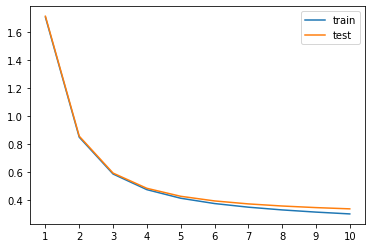

In [46]:
# 描画
plt.plot(list(range(1, nn.epoch + 1)), nn.loss_train, label = 'train')
plt.plot(list(range(1, nn.epoch + 1)), nn.loss_val, label = 'test') # change
plt.legend()
plt.xticks(list(range(1, nn.epoch + 1)))

【問題8】（アドバンス課題）誤分類の確認

誤分類した画像はどのようなものだったかを確認してください。推定値を用意し、以下のコードを実行してください。

《コード》

In [ ]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。
Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか

true_false = y_pred==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')
